In [1]:
#instalando dependências
!pip install graphviz==0.15
!pip install pydot
!apt-get install graphviz

  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
#bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from string import ascii_letters
from scipy.stats import randint


In [3]:
#importação de dados com o pandas
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
#simula uma situação horrível de "azar" onde as classes estão ordenadas por padrão
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [5]:
#utilizando o DummyClassifier como algoritmo de baseline
SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f%%, %.2f%%]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79%, 53.45%]


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [6]:
#cria um modelo de DecisionTreeClassifier utilizando os dados manipulados
SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f%%, %.2f%%]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83%, 77.73%]


In [7]:
#gera dados elatorios de modelo de carro para simulacao de agrupamento ao usar o estimador
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [8]:
#função para imprimir os resultados utilizando média e desvio padrão
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f%%" % media)
  print("Intervalo [%.2f%%, %.2f%%]" % (media - 2 * desvio, media + 2 * desvio))

In [9]:
#GroupKFold em um pipeline com StandardScaler e SVC
SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68%
Intervalo [74.28%, 79.08%]


In [10]:
#GroupKFold para analisar como o modelo se comporta com novos grupos
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)#profundidade = 2 
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78%
Intervalo [73.67%, 77.90%]


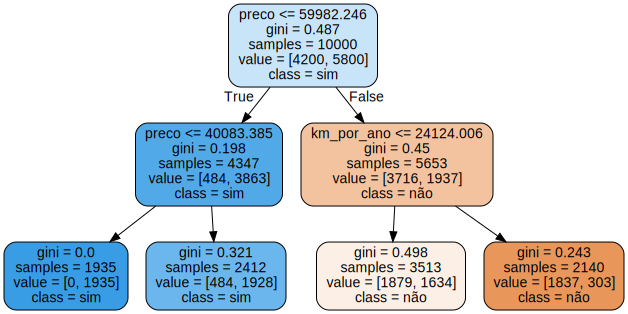

In [11]:
#plota o gráfico do modelo
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não', 'sim'], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [12]:
#testando o modelo com max_depth=3
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67%
Intervalo [76.40%, 80.94%]


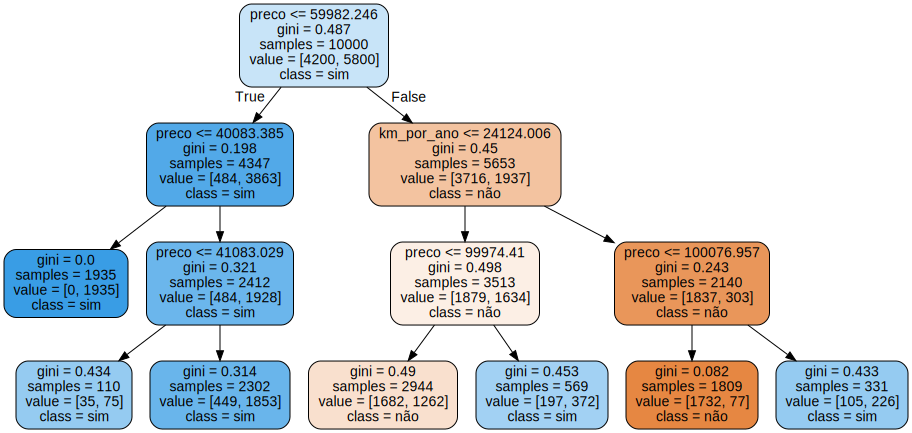

In [13]:
#plotando gráfico do modelo com max_depth=3
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não', 'sim'], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [14]:
#função para testar a árvore de decisão com diversos valores de max_depth 
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, train_score, test_score]
  print("Árvore max_depth = %d, treino = %.2f%%, teste = %.2f%%" % (max_depth, train_score, test_score))
  return tabela
#executa a função até 32 valores e cria um DataFrame pandas
resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth", "train", "test"])
resultados.head()
  

Árvore max_depth = 1, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, treino = 75.79%, teste = 75.78%
Árvore max_depth = 3, treino = 78.75%, teste = 78.67%
Árvore max_depth = 4, treino = 78.79%, teste = 78.63%
Árvore max_depth = 5, treino = 78.94%, teste = 78.56%
Árvore max_depth = 6, treino = 79.17%, teste = 78.12%
Árvore max_depth = 7, treino = 79.50%, teste = 77.96%
Árvore max_depth = 8, treino = 79.89%, teste = 77.86%
Árvore max_depth = 9, treino = 80.46%, teste = 77.38%
Árvore max_depth = 10, treino = 81.16%, teste = 77.19%
Árvore max_depth = 11, treino = 82.03%, teste = 76.97%
Árvore max_depth = 12, treino = 82.89%, teste = 76.49%
Árvore max_depth = 13, treino = 83.95%, teste = 75.81%
Árvore max_depth = 14, treino = 85.03%, teste = 75.66%
Árvore max_depth = 15, treino = 86.14%, teste = 75.16%
Árvore max_depth = 16, treino = 87.19%, teste = 75.11%
Árvore max_depth = 17, treino = 88.31%, teste = 74.74%
Árvore max_depth = 18, treino = 89.26%, teste = 74.33%
Árvore max_depth = 

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


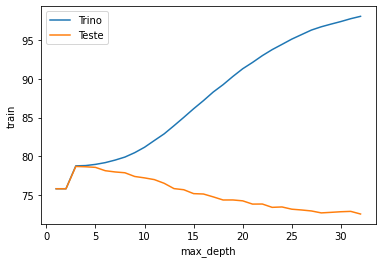

In [15]:
sns.lineplot(x = "max_depth", y = "train", data= resultados)
sns.lineplot(x = "max_depth", y = "test", data= resultados)
plt.legend(["Trino", "Teste"])

In [16]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


In [17]:
#testando a arvore de decisão com hiperparâmetros em 2 dimensões 
def roda_arvore_de_decisao(max_depth, min_samples_leaf ):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  print("Árvore max_depth = %d, min_samples_leaf = %d, treino = %.2f%%, teste = %.2f%%" % (max_depth, min_samples_leaf, train_score, test_score))
  return tabela

#executa a função diversas vezes para testar a progressão dos valores com hiperparâmtros
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth", "min_samples_leaf", "train", "test"]) #cria um DataFrame pandas
  return resultados

resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 192, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 512, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 192, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 512, treino = 75.79%, teste = 75.78%
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 192, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 512, treino = 77.53%, teste = 77.50%
Árvore max_depth = 4, min_samples_leaf = 128, treino = 78.75%, t

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [18]:
#verifica os melhores resultados
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


In [19]:
#verifica a correlação dos valores
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.354588,0.240852
min_samples_leaf,0.000000,1.000000,-0.637649,-0.440661
train,0.354588,-0.637649,1.000000,0.909222
test,0.240852,-0.440661,0.909222,1.000000


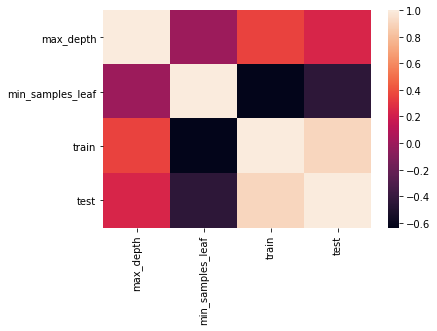

In [20]:
#mostra a correlação desses valores com um heatmap do seaborn
sns.heatmap(corr)

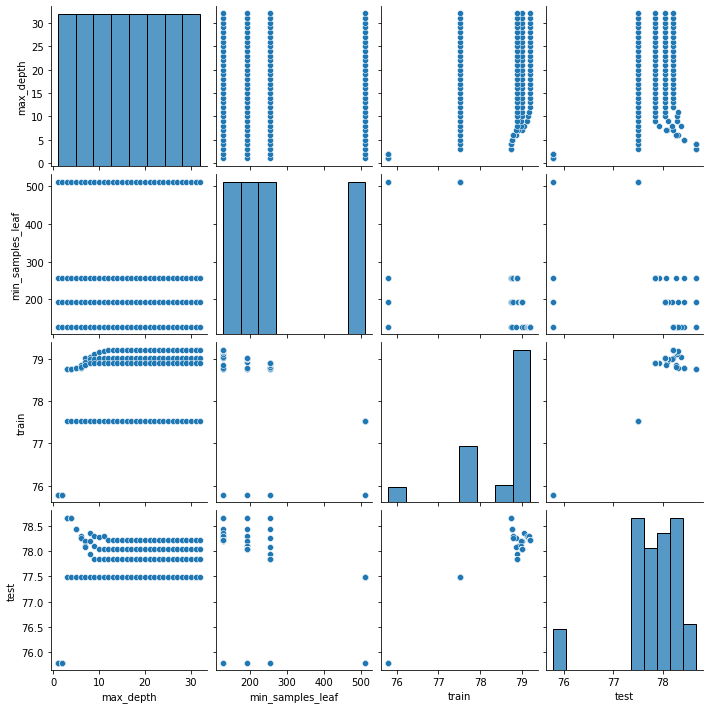

In [21]:
#mostra a correlação dos valores com o pairplot do seaborn
sns.pairplot(resultados)

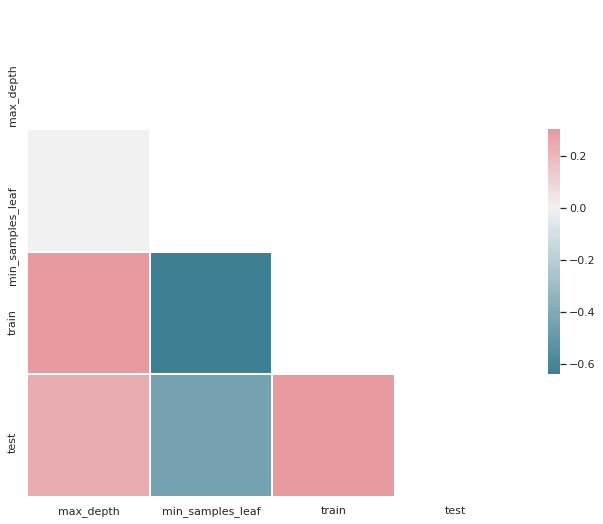

In [22]:
#outro tipo de gráfico de correlação do seaborn
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
#adiciona um terceiro hiperparâmetro para teste
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()  #calcula a média do tempo gasto no treino
  score_time = results['score_time'].mean() #calcula a média do tempo gasto nos testes
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.005377,0.001189
1,1,32,64,75.791169,75.784219,0.005279,0.001072
2,1,32,128,75.791169,75.784219,0.005095,0.001011
3,1,32,256,75.791169,75.784219,0.005128,0.001035
4,1,64,32,75.791169,75.784219,0.005133,0.001087


In [24]:
#matriz de correlação do novo modelo
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000,0.000000,0.000000,0.529391,0.011529,0.587960,0.539821
min_samples_leaf,0.000000,1.000000,0.000000,-0.341222,0.286555,-0.514439,-0.416040
min_samples_split,0.000000,0.000000,1.000000,-0.126171,0.132827,-0.065596,-0.050119
train,0.529391,-0.341222,-0.126171,1.000000,0.247850,0.905630,0.709026
test,0.011529,0.286555,0.132827,0.247850,1.000000,-0.021787,-0.007689
fit_time,0.587960,-0.514439,-0.065596,0.905630,-0.021787,1.000000,0.816196
score_time,0.539821,-0.416040,-0.050119,0.709026,-0.007689,0.816196,1.000000


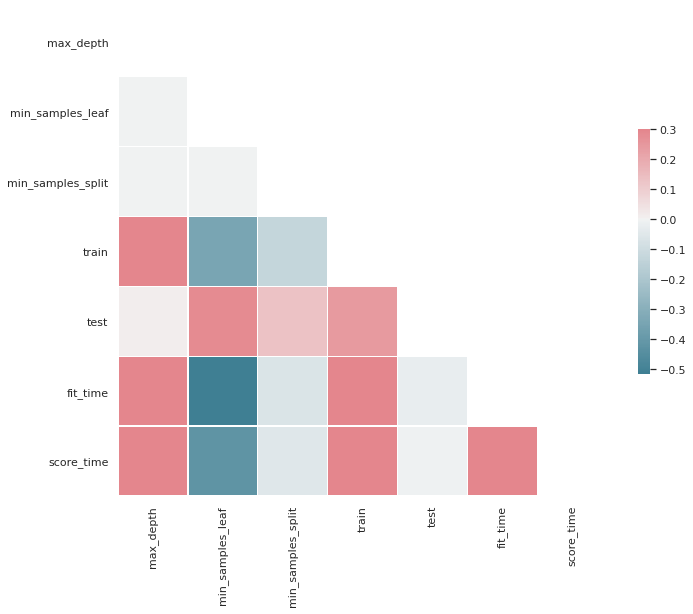

In [25]:
#mostra gráfico de correlação
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
#mostra os resultados de forma decrescente
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.011486,0.001107
48,4,32,32,78.750993,78.672633,0.012025,0.001132
34,3,32,128,78.750993,78.672633,0.010255,0.001221
35,3,32,256,78.750993,78.672633,0.010179,0.001123
36,3,64,32,78.750993,78.672633,0.009982,0.001177


In [27]:
#utiliza o método GridSearchCV para específicar os parâmetros do estimador utilizando os dados gerados em x_azar e y_azar
SEED = 301
np.random.seed(SEED)

hiperparametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     hiperparametros,
                     cv = GroupKFold(n_splits= 10))
busca.fit(x_azar, y_azar , groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010672,0.001072,0.001178,0.000095,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010575,0.000704,0.001215,0.000102,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.010115,0.000391,0.001188,0.000140,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.010195,0.000487,0.001162,0.000063,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.010357,0.001030,0.001177,0.000165,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [28]:
#utiliza métodos best_params_ e best_score_ para verificar as melhores opções
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [29]:
#seleciona a melhor opção dentre os parametros verificados
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
#verifica a acurácia do modelo
predicoes = melhor.predict(x_azar)
acuracia = accuracy_score(predicoes, y_azar) * 100
print("Acurácia para os dados foi %.2f%%" % acuracia)

Acurácia para os dados foi 78.75%


In [31]:
#testando modelo com o método RandomizedSearchCV utilizando os dados gerados em x_azar e y_azar
SEED = 301
np.random.seed(SEED)

hiperparametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     hiperparametros,
                     cv = KFold(n_splits= 5, shuffle = True),
                     random_state = SEED,
                     n_iter = 16)
busca.fit(x_azar, y_azar , groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013591,0.002498,0.001408,0.000358,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.008905,0.000112,0.001147,0.000014,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.008838,0.000049,0.001136,0.000010,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.018942,0.000242,0.001462,0.000155,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.018940,0.000211,0.001430,0.000061,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [32]:
#
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7825, 0.783 , 0.794 , 0.781 , 0.795 ])

In [33]:
#função para imprimir os resultados do cross_val_score
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [34]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.70
Intervalo [76.85, 80.55]


In [35]:
#utlizando o RandomizedSearchCV com hiperparâmetros customizados para comparação
SEED = 301
np.random.seed(SEED)

hiperparametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     hiperparametros,
                     cv = KFold(n_splits= 5, shuffle = True),
                     random_state = SEED,
                     n_iter = 16)
busca.fit(x_azar, y_azar , groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013297,0.000179,0.001314,0.000094,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.016570,0.000435,0.001371,0.000087,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.015562,0.000271,0.001412,0.000071,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.019940,0.001125,0.001441,0.000103,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.015081,0.000455,0.001290,0.000068,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [36]:
#verifica os scores com cross_val_score
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [37]:
#mostra os valores médios de pontuação dos testes de forma descrescente
resultados_ordenados = resultados.sort_values('mean_test_score', ascending = False)
for indice, linha in resultados_ordenados.iterrows():
  print("%.3f += (%.3f) %s" %(linha.mean_test_score, linha.std_test_score *2, linha.params))


0.787 += (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 += (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 += (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 += (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 += (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 += (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 += (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 += (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 += (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 += (0.014) {'criterion': 'entropy', 

In [38]:
#roda o modelo de RandomizedSearchCV com 64 iterações
SEED = 301
np.random.seed(SEED)

hiperparametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     hiperparametros,
                     cv = KFold(n_splits= 5, shuffle = True),
                     random_state = SEED,
                     n_iter = 64)
busca.fit(x_azar, y_azar , groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013543,0.000980,0.001219,0.000041,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.016524,0.000392,0.001278,0.000046,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.015472,0.000663,0.001400,0.000092,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.019817,0.001081,0.001371,0.000034,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.015258,0.000350,0.001356,0.000097,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [39]:
#mostra os valores médios de pontuação dos testes de forma descrescente
resultados_ordenados = resultados.sort_values('mean_test_score', ascending = False)
for indice, linha in resultados_ordenados.iterrows():
  print("%.3f += (%.3f) %s" %(linha.mean_test_score, linha.std_test_score *2, linha.params))

0.787 += (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 += (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 += (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 += (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 += (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 += (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 += (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 += (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 += (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 += (0.024) {'criterion': 'gini', 'max_de

In [40]:
#verifica os scores com cross_val_score
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.66
Intervalo [76.79, 80.53]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [41]:
#testando o modelo com o classificador RandomForestClassifier
SEED=301
np.random.seed(SEED)

hiperparametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}


busca = GridSearchCV(RandomForestClassifier(),
                    hiperparametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035960,0.001428,0.003604,0.000104,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.331955,0.006960,0.020258,0.001232,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.035639,0.000757,0.003427,0.000046,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.326065,0.001142,0.019550,0.000244,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.034973,0.001427,0.003450,0.000165,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [42]:
#ajusta o modelo com o classificador RandomForestClassifier e RandomizedSearchCV
SEED=301
np.random.seed(SEED)

hiperparametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}


busca = RandomizedSearchCV(RandomForestClassifier(),
                    hiperparametros,
                    n_iter = 20, #limita as iterações para 20 com o objetivo de reduzir o tempo de processamento
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.418771,0.008736,0.021187,0.002447,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.057592,0.004020,0.003838,0.000051,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.569816,0.005410,0.022844,0.000325,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.035479,0.000644,0.003547,0.000194,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.057430,0.003213,0.003633,0.000126,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [43]:
#mostra os valores médios de pontuação dos testes de forma descrescente
resultados_ordenados = resultados.sort_values('mean_test_score', ascending = False)
for indice, linha in resultados_ordenados.iterrows():
  print("%.3f += (%.3f) %s" %(linha.mean_test_score, linha.std_test_score *2, linha.params))

0.776 += (0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 += (0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 += (0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 += (0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 += (0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
0.775 += (0.022) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775 += (0.022) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'entrop